<a href="https://colab.research.google.com/github/Lilly-yang/UCA--Machine_Learning_and_Computer_Vision/blob/main/Project_Automatic_Signal_Detector_3_5%2C8_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Automatic Signal Detector**
Task 3 - Task 5, Task 8

## README

The goal of this progress is to automatically detect hand signal.
- Reads the camera in Google Colab and run facedetect (Boosting)
- Initiate CamShift for skin histogram
- Track face by CamShift and remove face 
- Track hand by CamShift with initial skin histogram
- Generate a gray scale image of the probability of hand, resize the image to (1,256).
- Pass this image to loaded model and predict
- Show the predicted signal


### Getting Started
There are face-detecte model (.xml file) and signal-detect models in my Google driver will be used in this progress. Make sure you are mounted [my Google driver](https://drive.google.com/drive/folders/1SyAjYyn7sxlJULhwh1kkbA71xfAGkk2A?usp=sharing).

* _haarcascade_frontalface_alt.xml_
* _model.json_
* _model_weights.h5_


### Running the progress
1. Running cells in each part
2. Runing cell of `App().run()` to start hand signal detection


### Authors
Li YANG   li.yang-li@etu.univ-cotedazur.fr

## Mounted Google Driver

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Camera Capture
Using a webcam by JavaScript code to capture images in Google Colab for processing on the runtime.

PS: this cell of code (except comments) were copied from our course webpage.

In [ ]:
# %matplotlib notebook
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import numpy as np
from PIL import Image
import io
import cv2 as cv

def VideoCapture():
  js = Javascript('''
    async function create(){
      div = document.createElement('div');
      document.body.appendChild(div);

      video = document.createElement('video');
      video.setAttribute('playsinline', '');

      div.appendChild(video);

      stream = await navigator.mediaDevices.getUserMedia({video: {facingMode: "environment"}});
      video.srcObject = stream;

      await video.play();

      canvas =  document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);

      div_out = document.createElement('div');
      document.body.appendChild(div_out);
      img = document.createElement('img');
      div_out.appendChild(img);
    }

    async function capture(){
        return await new Promise(function(resolve, reject){
            pendingResolve = resolve;
            canvas.getContext('2d').drawImage(video, 0, 0);
            result = canvas.toDataURL('image/jpeg', 0.8);
            pendingResolve(result);
        })
    }

    function showimg(imgb64){
        img.src = "data:image/jpg;base64," + imgb64;
    }

  ''')
  display(js)

def byte2image(byte):
  jpeg = b64decode(byte.split(',')[1])
  im = Image.open(io.BytesIO(jpeg))
  return np.array(im)

def image2byte(image):
  image = Image.fromarray(image)
  buffer = io.BytesIO()
  image.save(buffer, 'jpeg')
  buffer.seek(0)
  x = b64encode(buffer.read()).decode('utf-8')
  return x

## Face Detection
This progress use haar cascades.

USAGE: `facedetect.py [--cascade <cascade_fn>] [--nested-cascade <cascade_fn>] [<video_source>]`

Below are main function of Face detectation:
* This module uses a model file (_haarcascade_frontalface_alt.xml_) and needs to mount my Google Driver
* The function returns only when a face is detected

In [ ]:
## Detect face by trained model in each grid of the giving image:
##   if there is a face in the image then return the indexation of the rectangel are
##   if there is not any face in the image then return a empty list: []
def detect(img, cascade):
    rects = cascade.detectMultiScale(img, scaleFactor=1.3, minNeighbors=4, minSize=(30, 30),
                                     flags=cv.CASCADE_SCALE_IMAGE)
    if len(rects) == 0:
        return []
    rects[:,2:] += rects[:,:2]
    return rects


## Loding models from Google Driver 
cascade_fn = "/content/drive/My Drive/MLCV/haarcascade_frontalface_alt.xml"
# print('load model done!')
cascade = cv.CascadeClassifier(cv.samples.findFile(cascade_fn))


def facedetect():
  ## ensure the camera caoture function is was initaled, otherwise uncomment below cod
  # VideoCapture()
  # eval_js('create()')

  rects = []  # initial rects as [] for detect face from whole image

  ## Main function of On-time Face Detection
  while True:
    ## capture image and tralate to array d-type
    byte = eval_js('capture()')
    img = byte2image(byte)
    # print(np.shape(img))  # (480, 640, 3)

    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    gray = cv.equalizeHist(gray)

    ## detect giving image by model
    rects = detect(gray, cascade)

    ## Return detected inf if it exits
    if len(rects) != 0:
      return tuple(rects[0]), img
      break

## Timing
Here are the functions for timing and displaying time (copied from GitHub)

In [ ]:
## Function for timing
def clock():
    return cv.getTickCount() / cv.getTickFrequency()

## Function for imformation presentation of captured image
def draw_str(dst, target, s):
    x, y = target
    cv.putText(dst, s, (x+1, y+1), cv.FONT_HERSHEY_PLAIN, 1.0, (0, 0, 0), thickness = 2, lineType=cv.LINE_AA)
    cv.putText(dst, s, (x, y), cv.FONT_HERSHEY_PLAIN, 1.0, (255, 255, 255), lineType=cv.LINE_AA)

## Button
!!!Using a webcam to capture images for processing on the runtime.

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

## Loda singal detection model

In [ ]:
from keras.models import model_from_json

# load json and create model
json_file = open('/content/drive/My Drive/MLCV/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/My Drive/MLCV/model_weights.h5")

## Hand Signal Detection
This progress use Camshift.

- Detecting face: **Executed when the class `App()` is initialized, meaning it will only be executed once like a mouse grab.**
- Initiate CamShift for skin histogram.
- Detecting hand:
  
  - Detecting face from detected face are by Camshift: **I commented codes that can reduce the detection frame to near the face because this does not reduce time since the nature of Camshift.**
  - Removing face by set `prob[face_area] = 0`.
  - Detecting hand on prob_img without face:
    - First time detect hand from face area;
    - **from second time, detect hand from detected hand area: faster and roboster.**
  - Saving `prob[hand_area]` as .jpg in driver: 
    - **I reshape the size of original img to `(16,16) ` and `(224,224)`;**
    - images are saved in [/content/drive/My Drive/MLCV/hand_img](https://drive.google.com/open?id=1dpsdVebrX5CzHyDeXWeP8g9Y1HJnwTUT).

In [ ]:
import sys
PY3 = sys.version_info[0] == 3

if PY3:
    xrange = range


class App():
    def __init__(self):
      ## replaced below codes by VideoCapture() function above to initial camera caoture
      # self.cam = video.create_capture(video_src, presets['cube'])
      # _ret, self.frame = self.cam.read()
      VideoCapture()
      eval_js('create()')

      ## replaced mousetrack by Facedetect() function above which can be done once and ensure return a face anxis
      # cv.setMouseCallback('camshift', self.onmouse)
      self.selection, self.frame = facedetect()
      xmin, ymin, xmax, ymax = self.selection
      self.track_window = (xmin, ymin, xmax - xmin, ymax - ymin)
      
      ## some initial variable setting
      # self.drag_start = None
      self.show_backproj = True
      self.reduce_track_window = False
      self.hand_track_window = False
      self.indx = 0

    ## No need to perform mouse grab in colab  
    # def onmouse(self, event, x, y, flags, param):
    #     if event == cv.EVENT_LBUTTONDOWN:
    #         self.drag_start = (x, y)
    #         self.track_window = None
    #     if self.drag_start:
    #         xmin = min(x, self.drag_start[0])
    #         ymin = min(y, self.drag_start[1])
    #         xmax = max(x, self.drag_start[0])
    #         ymax = max(y, self.drag_start[1])
    #         self.selection = (xmin, ymin, xmax, ymax)
          # indicates that left mouse button is released.
    #     if event == cv.EVENT_LBUTTONUP:
    #         self.drag_start = None
    #         self.track_window = (xmin, ymin, xmax - xmin, ymax - ymin)

    ## Functions for displaying histograms（copied from GitHub)
    def show_hist(self):
        bin_count = self.hist.shape[0]
        bin_w = 24
        img = np.zeros((256, bin_count*bin_w, 3), np.uint8)
        for i in xrange(bin_count):
            h = int(self.hist[i])
            cv.rectangle(img, (i*bin_w+2, 255), ((i+1)*bin_w-2, 255-h), (int(180.0*i/bin_count), 255, 255), -1)
        img = cv.cvtColor(img, cv.COLOR_HSV2BGR)
        # cv.imshow('hist', img)
        eval_js('showimg("{}")'.format(image2byte(img)))
    
    ## Main function to detect hand
    def run(self):
        while True:
          ## get time of start detectation
          t = clock()

          ## Replace function to get image from camera
          # _ret, self.frame = self.cam.read()
          byte = eval_js('capture()')
          self.frame = byte2image(byte)
          # print(np.shape(self.frame)) #(480,640,3)
          
          ## preprossing image
          vis = self.frame.copy()
          hsv = cv.cvtColor(self.frame, cv.COLOR_BGR2HSV)
          mask = cv.inRange(hsv, np.array((0., 60., 32.)), np.array((180., 255., 255.)))  #thresholding operations

          ## initiate CamShift for skin histogram, just do it once
          if self.selection:
            x0, y0, x1, y1 = self.selection
            hsv_roi = hsv[y0:y1, x0:x1]
            mask_roi = mask[y0:y1, x0:x1]
            hist = cv.calcHist( [hsv_roi], [0], mask_roi, [16], [0, 180] )
            cv.normalize(hist, hist, 0, 255, cv.NORM_MINMAX)
            self.hist = hist.reshape(-1)
            # self.show_hist()

            ## Inverts image for show
            vis_roi = vis[y0:y1, x0:x1]
            cv.bitwise_not(vis_roi, vis_roi)
            vis[mask == 0] = 0

          ## from face detect -> hand detect
          if self.track_window and self.track_window[2] > 0 and self.track_window[3] > 0:
            self.selection = None

            ## Get probabilistic image (feature image) and conbine with mask
            prob = cv.calcBackProject([hsv], [0], self.hist, [0, 180], 1)
            prob &= mask

            ## camshaft algorithm operation parameter setting
            term_crit = ( cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 1 )

            ### Face-Detect
            ## Detection area reduced to adjacent areas
            # if self.reduce_track_window:
            #   xx1 = x0-50 if x0>50 else 0
            #   yy1 = y0-50 if y0>50 else 0
            #   xx2 = x1+50 if x1+50 < 640 else 640
            #   yy2 = y1+50 if y1+50 < 480 else 480
            #   prob = prob[yy1:yy1+yy2, xx1:xx1+xx2]
            #   self.track_window = list(self.track_window)
            #   self.track_window[0] = x0-xx1
            #   self.track_window[1] = y0-yy1
            #   self.track_window = tuple(self.track_window)

            track_box, self.track_window = cv.CamShift(prob, self.track_window, term_crit)

            ## Result extend to original size if decraced detect area before
            # if self.reduce_track_window:
            #   track_box = list(track_box)
            #   track_box[0] = list(track_box[0])
            #   track_box[0][0] += xx1
            #   track_box[0][1] += yy1
            #   track_box[0] = tuple(track_box[0])
            #   track_box = tuple(track_box)
            #   self.track_window = list(self.track_window)
            #   self.track_window[0] += xx1
            #   self.track_window[1] += yy1
            #   self.track_window = tuple(self.track_window)

            ### Remove face area
            xmin, ymin, xmax, ymax = self.track_window
            prob[ymin:ymin+ymax+1, xmin:xmin+xmax+1] = 0

            ### Hand-Detect
            if self.hand_track_window:
              track_box, self.hand_track_window = cv.CamShift(prob, self.hand_track_window, term_crit)
            else:
              track_box, self.hand_track_window = cv.CamShift(prob, self.track_window, term_crit)

            ### Saving detected hand area as imges with size (16,16) and (224,224)
            xmin, ymin, xmax, ymax = self.hand_track_window
            self.indx += 1
            # cv.imwrite('/content/drive/My Drive/MLCV/hand_img/'+'X_'+str(self.indx)+'_cut_ori.jpg', prob[ymin:ymin+ymax, xmin:xmin+xmax])
            # print(xmax, ymax)
            # increase the size of detect window
            xx1 = xmin-65 if xmin-65>0 else 0
            yy1 = ymin-80 if ymin-80>0 else 0
            xx2 = xmin+xmax+35 if xmin+xmax+35 < 640 else 640
            yy2 = ymin+ymax+20 if ymin+ymax+20 < 480 else 480
            img = prob[yy1:yy2, xx1:xx2]
            # print(np.shape(img))
            
            ## resize and save imges
            # cv.imwrite('/content/drive/My Drive/MLCV/hand_img/'+'L_'+str(self.indx)+'_cut.jpg', img)
            img1 = cv.resize(img, (16,16))
            # img2 = cv.resize(img, (224,224))
            # cv.imwrite('/content/drive/My Drive/MLCV/hand_img/'+'L_'+str(self.indx)+'_16.jpg', img1)
            # cv.imwrite('/content/drive/My Drive/MLCV/hand_img/'+'X_'+str(self.indx)+'.jpg', prob)
            # cv.imwrite('/content/drive/My Drive/MLCV/hand_img/'+str(self.indx)+'_hand_224x224.jpg', img2)

            ## prediction
            hand_image = np.resize(img1, (1,256))
            prediction = loaded_model.predict(hand_image) ## where hand_image is the probability image of your hand of size (1,256)
            prediction = prediction.argmax()
            predicted_letter = chr(ord('A') + prediction)
            # print(predicted_letter)

            ### show backproject
            if self.show_backproj:
                vis[:] = prob[...,np.newaxis]
                       
            ### Hook the detection area with an ellipse on the original image
            try:
              cv.ellipse(vis, track_box, (0, 0, 255), 2)
            except:
              print(track_box)

          ### Calculate detection time and display on original image
          dt = clock() - t
          draw_str(vis, (20, 20), 'time: %.1f ms' % (dt*1000))
          # draw_str(vis, (40, 40), 'Index: %d' % (self.indx))
          draw_str(vis, (40, 40), 'signal: %s' % (predicted_letter))

          ### Replace imshow() function by java code above
          # cv.imshow('camshift', vis)
          eval_js('showimg("{}")'.format(image2byte(vis)))

## Run hand-detect by Camshift

When we run the following class `App()`, the face detection is executed during initialization, and we ensure that we can get the result of the face detection before executing the `run()` function.

In [ ]:
App().run()

<IPython.core.display.Javascript object>

KeyboardInterrupt: ignored

### Comments for test
**I tested all 11 letters（A,B,C,F,I,L,O,V,W,X,Y) for training：**

Firstly，there is no problem with the test procedure. 
  * It is worth noting that my hand detection is based on the hand position of the previous picture (in order to speed up), so when the hand leaves the detection area, you need to use your hand to lead the detection area to the hand.



In [ ]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

img_A = cv.imread('/content/drive/My Drive/MLCV/predicted_imgs/A.png')
img_B = cv.imread('/content/drive/My Drive/MLCV/predicted_imgs/B.png')
img_C = cv.imread('/content/drive/My Drive/MLCV/predicted_imgs/C.png')
img_F = cv.imread('/content/drive/My Drive/MLCV/predicted_imgs/F.png')
img_I = cv.imread('/content/drive/My Drive/MLCV/predicted_imgs/I.png')
img_L = cv.imread('/content/drive/My Drive/MLCV/predicted_imgs/L.png')
img_O = cv.imread('/content/drive/My Drive/MLCV/predicted_imgs/O.png')
img_V = cv.imread('/content/drive/My Drive/MLCV/predicted_imgs/V.png')
img_W = cv.imread('/content/drive/My Drive/MLCV/predicted_imgs/W.png')
img_X = cv.imread('/content/drive/My Drive/MLCV/predicted_imgs/X.png')
img_Y = cv.imread('/content/drive/My Drive/MLCV/predicted_imgs/Y.png')

img = [['F',img_F], ['I',img_I], ['L',img_L], ['O',img_O], ['X',img_X], ['Y',img_Y], ['A',img_A], ['B',img_B], ['C',img_C], ['V',img_V], ['W',img_W]]

**For these 6 letters I made by my self with right hand('F, I, L, O, X, V, W'):**

- I used right hand when testing. 

- These 6 letters were eazy to be resongnized with any bias. 
  - Reason 1: the bacgroud is same as these training data(which I made by my self in same environment).
  - Reason 2: the preprocesse is same as these training data(I expanded the border when i getting the hand are.) 

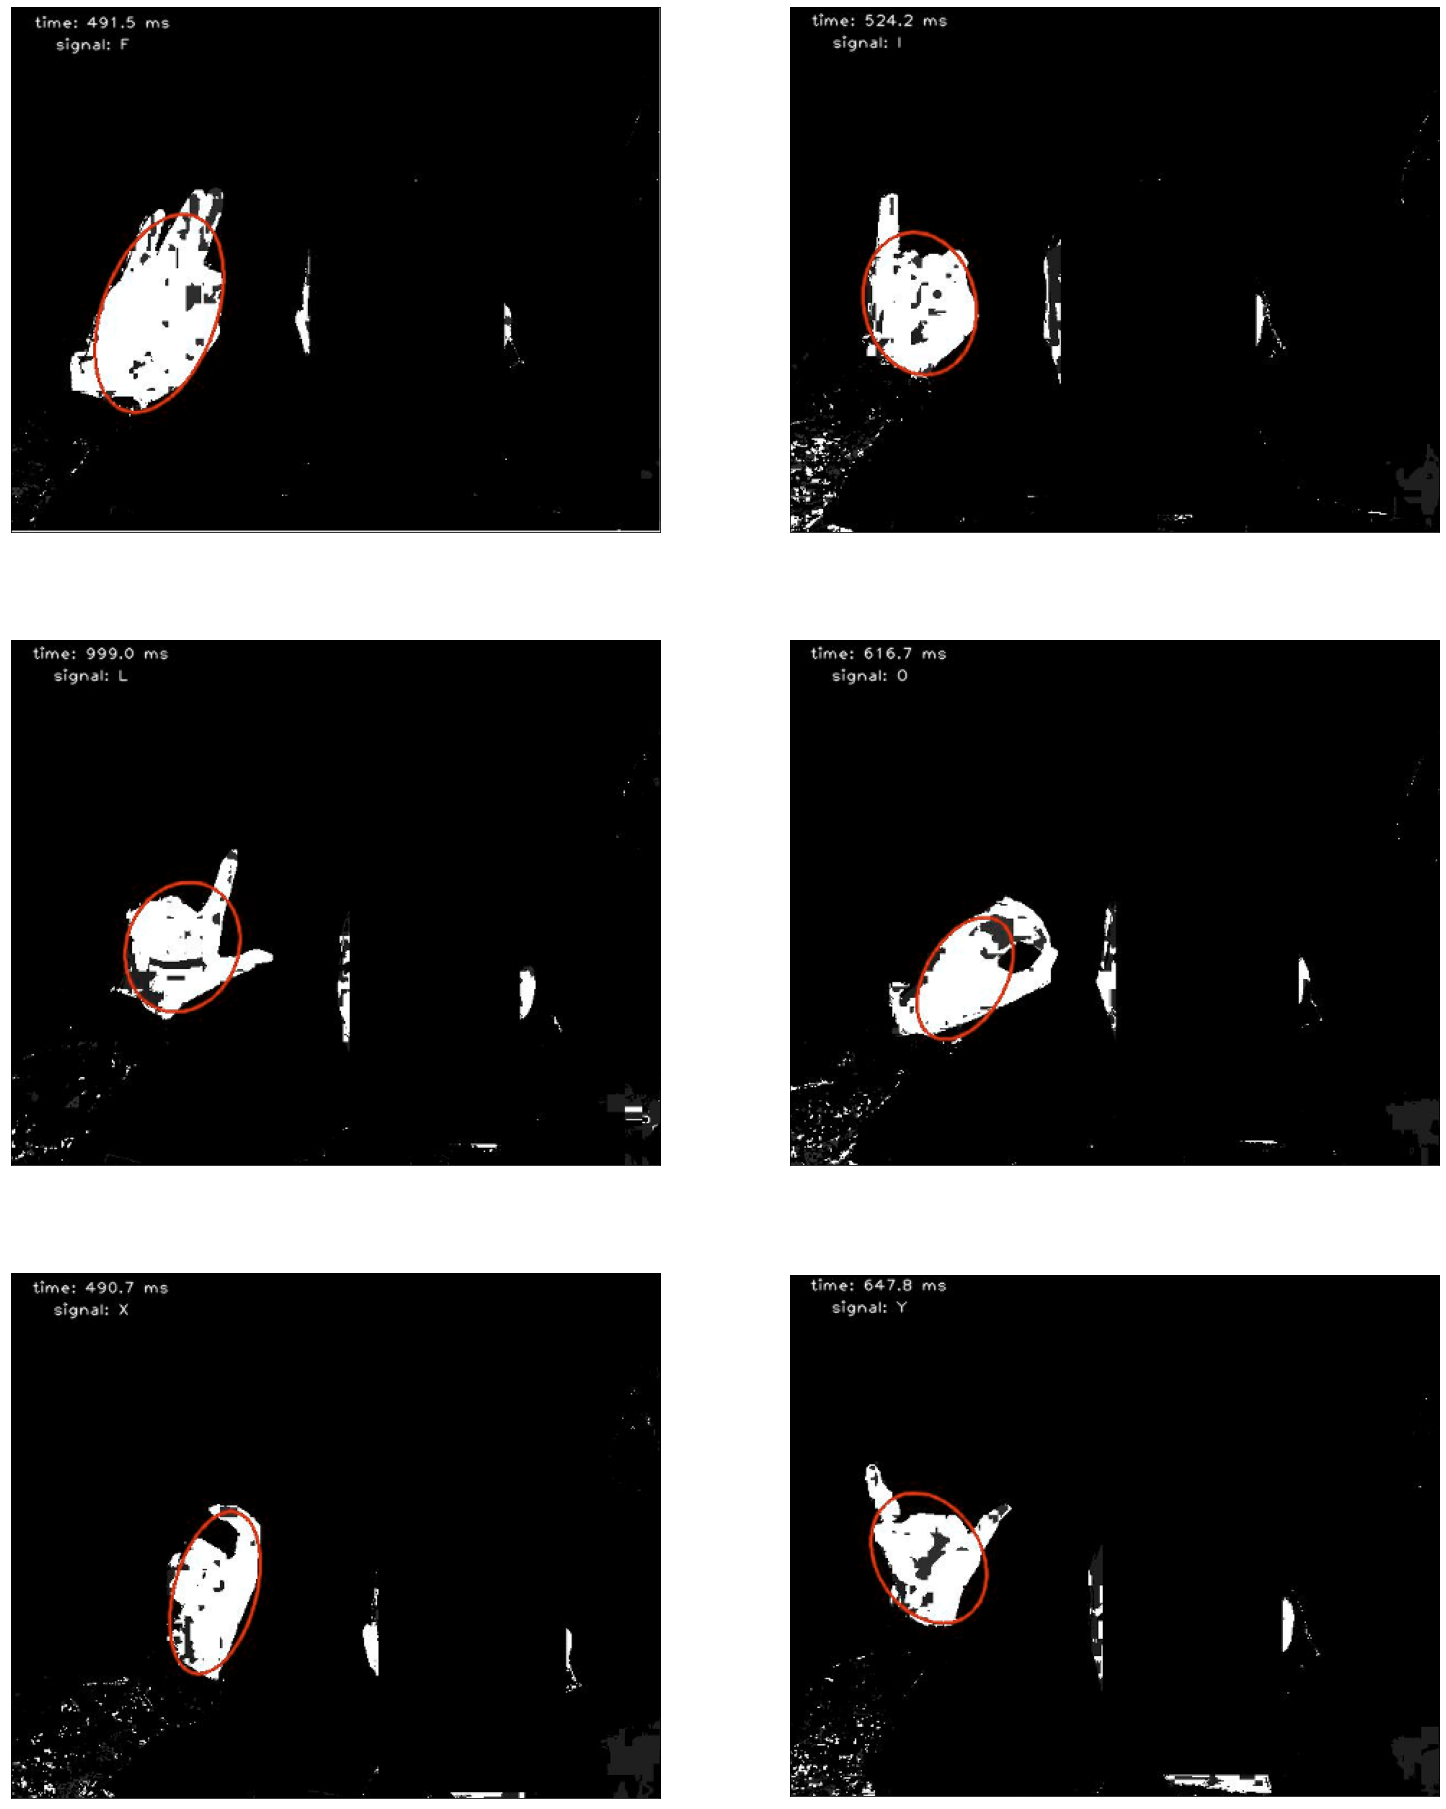

In [ ]:
plt.figure(figsize=(25.6, 33))
for i in range(6):
  ax = plt.subplot(3,2,i+1)
  # ax.set_title(img[i][0])
  plt.imshow(img[i][1])
  plt.xticks([])
  plt.yticks([])
plt.show()

**For these 5 letters I got from my mate which she made them with left hand('A, B, C, V, W'):**

- I used left hand when testing.
- These 5 letters were hard to be recongnized. 
  - Reason 1: my mate and I genarated these training data in different environment which cause the bacgroud of these images are different. When i testing the images i get was different from training data for these 5 letters.
  - Reason 2: my mate didn't enpanded border for her data. I did some change for cutting part of my progress. I didn't expanded border so much so that the model can recongnized these 5 letters but still not that easy compared with these 6 letters above which I made by my self. I need to try a good position to match these training data better.

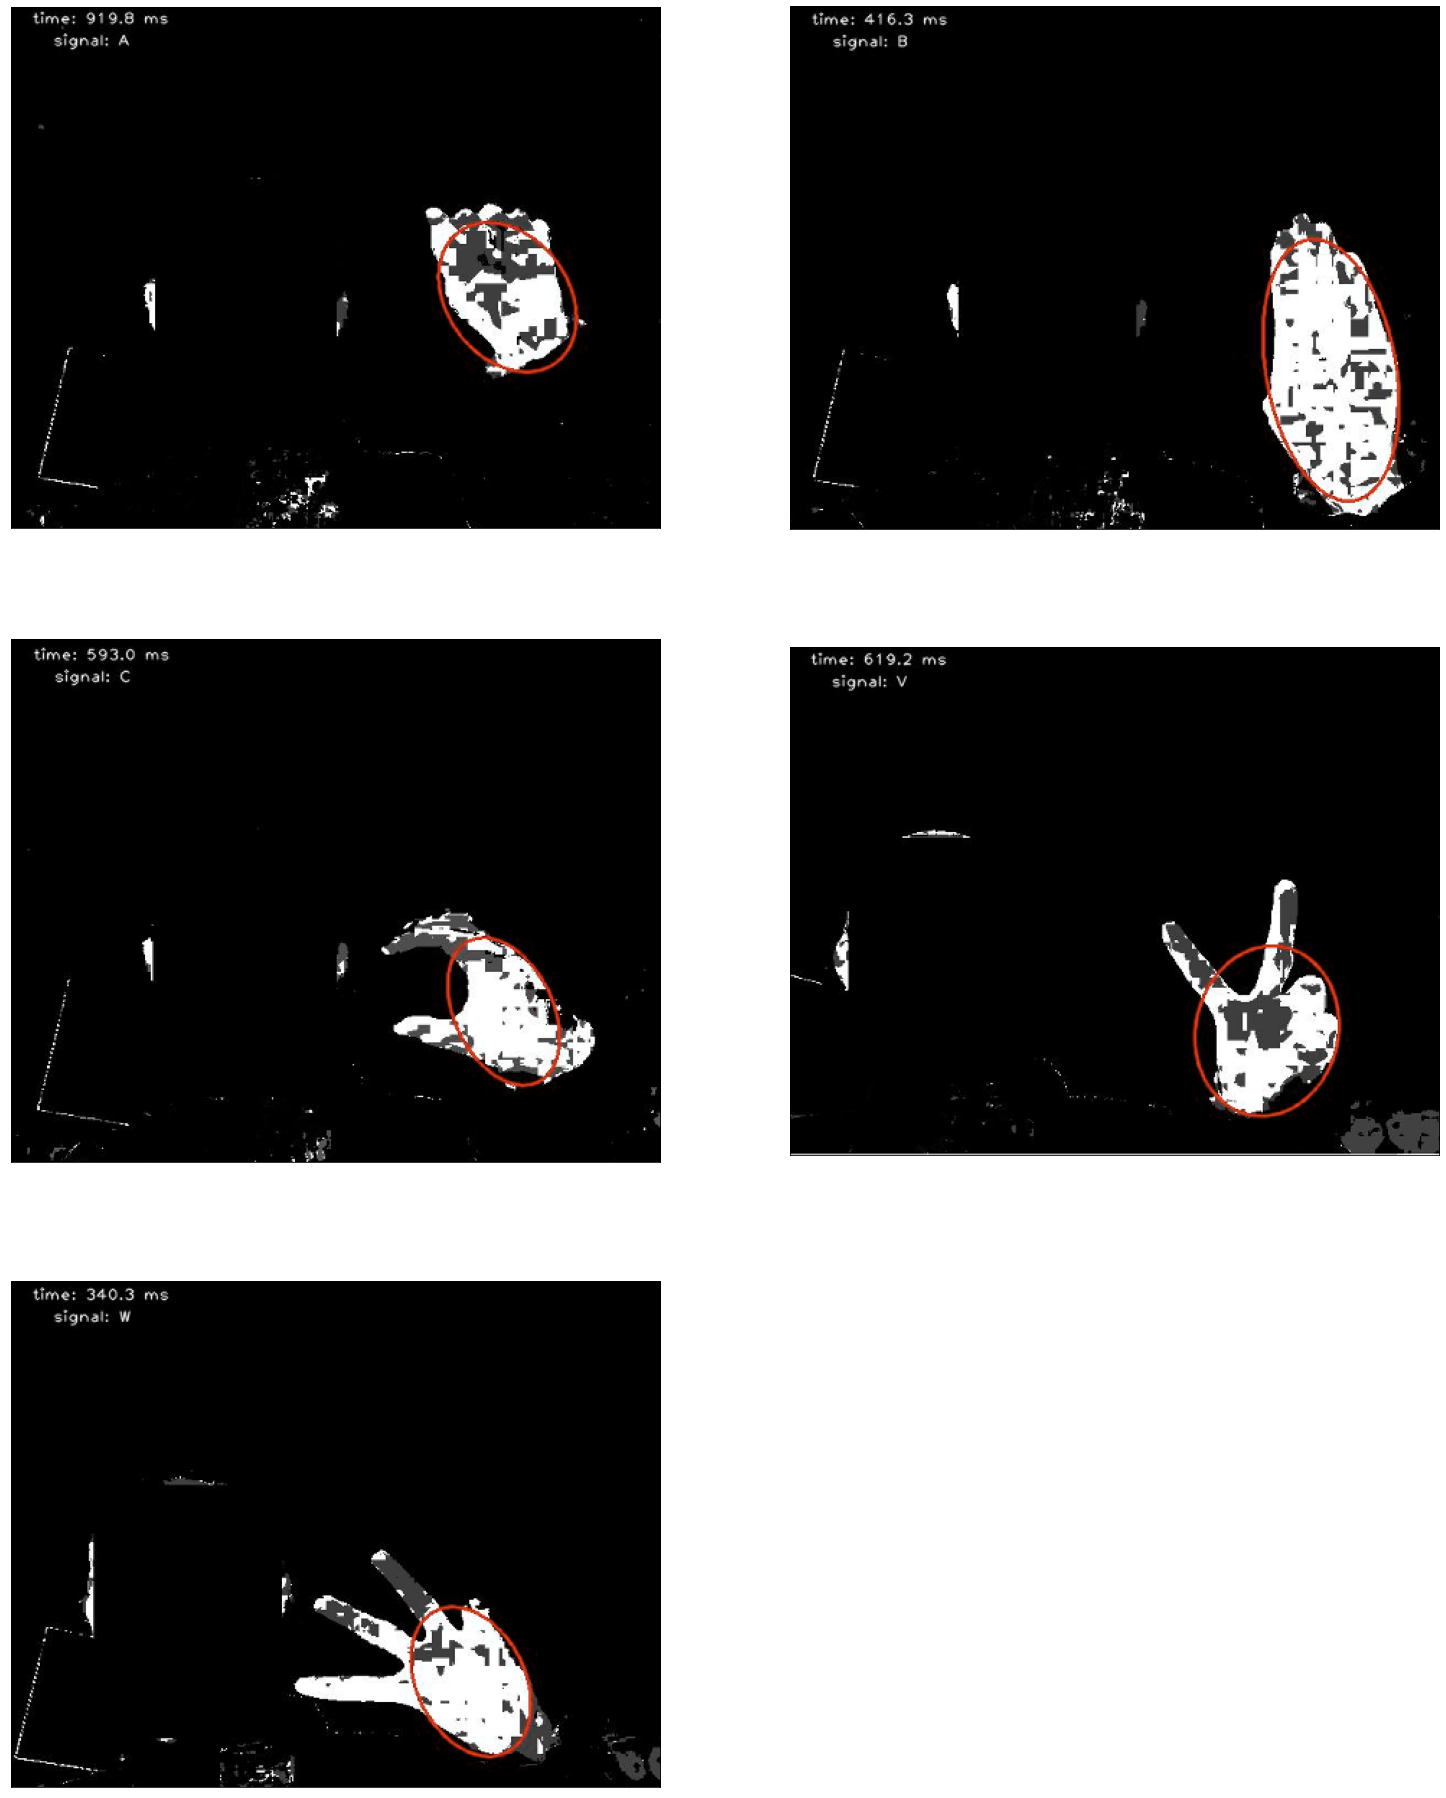

In [ ]:
plt.figure(figsize=(25.6, 33))
for i in range(6,11):
  ax = plt.subplot(3,2,i-5)
  # ax.set_title(img[i][0])
  plt.imshow(img[i][1])
  plt.xticks([])
  plt.yticks([])
plt.show()

## Conclution

⚠️ In the previous task, I found that the lighting in the bathroom (warm color, white background) is better than the bedroom or natural lighting, so my process of generating data and testing the model is carried out in bathroom. When running my program, it is best to choose an environment with warm and strong light and a single background.

1. For the 11 classifications (996 data), the model has sufficient learning ability.
```
    Validation loss: 0.13428444683551788
    Validation accuracy: 0.9599999785423279
```

2. The unification of the testing set and the training set is a key factor that affects the test effect, and it should avoided too many differences.
